In [1]:
import torch
import torch.nn as nn
import os # dataset
import pandas as pd # dataset
from PIL import Image # dataset
import torchvision.transforms as transforms # train
import torch.optim as optim # train
import torchvision.transforms.functional as FT # train
#from tqdm import tqdm # train
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import DataLoader # train
import numpy as np # box utils
import matplotlib.pyplot as plt # box utils
import matplotlib.patches as patches # box utils
from collections import Counter # box utils

import albumentations as A # train
from albumentations.pytorch import ToTensorV2 # train

from torchvision import models
from torchsummary import summary # main
import matplotlib.pyplot as plt # plot functions (loss and mAP curves)

<center><img src='fig/YOLO-v1-network.png'><center>

In [2]:
'''
model
'''
# nout = [(nin + 2*p - k)/s] + 1
# nin = number of input features
# nout = number of output features
# k = convolution kernel size
# p = convolution padding size
# s = convolution stride size
architecture_config = [
    # Tuple: (kernel_size, num_filters, stride, padding)
    (7, 64, 2, 3), # original size
    #(7, 64, 3, (18, 98)), # this was done to keep the 224x224 ratio after this layer
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    # List: two tuples and then last integer represents number of repeats
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

# CNN block will be a conv layer, the batch norm and then a relu
class CNNBlock(nn.Module):
    # our **kwargs will be split_size, num_boxes, num_classes
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        # we are going to use batchnorm, so bias = False
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

# 3 channels because of the bgr images
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        # the model in the beginning of this block
        self.architecture = architecture_config
        # the number of channels of the image
        self.in_channels = in_channels
        # the conv layers mirror what Redmon did in his darknet
        self.darknet = self._create_conv_layers(self.architecture)
        # fully connected
        self.fcs = self._create_fcs(**kwargs)
    
    def forward(self, x):
        x = self.darknet(x)
        # start_dim = 1 to not flatten the number of examples
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_conv_layers(self, architecture):
        # all layers will be added in this empty list, created from the architecture
        layers = []
        in_channels = self.in_channels
        
        # this will go over every tuple/list in the architecture
        for x in architecture:
            # for a tuple, we add a CNNBlock
            if type(x) == tuple:
                # x arguments for a tuple being (kernel_size, num_filters, stride, padding)
                # x[0] = kernel_size
                # x[1] = num_filters
                # x[2] = stride
                # x[3] = padding
                layers += [CNNBlock(in_channels=in_channels,
                                  out_channels=x[1],
                                  kernel_size=x[0],
                                  stride=x[2],
                                  padding=x[3],
                                 )
                         ]
                # in_channels has to change for the next element
                # to the format outputted by this tuple
                in_channels = x[1]
                #print(x[1])
                
            # for the "M" in the architecture a maxpool layer is added
            elif type(x) == str:
                # kernel_size and stride are both 2x2 and a single argument of 2
                # is understood as (2, 2)
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            
            # the lists in the architecture all consist of two tuples and
            # a last integer that represents number of repeats
            elif type(x) == list:
                conv1 = x[0] # tuple
                conv2 = x[1] # tuple
                num_repeats = x[2] # integer

                # the indexes of the tuple elements are the same as the singular tuples:
                # conv[0] = kernel_size
                # conv[1] = num_filters
                # conv[2] = stride
                # conv[3] = padding
                for _ in range(num_repeats):
                    # first we add the first tuple of the list
                    layers += [CNNBlock(in_channels=in_channels,
                                        out_channels=conv1[1],
                                        kernel_size=conv1[0],
                                        stride=conv1[2],
                                        padding=conv1[3],
                                        )
                              ]
                    # then the second tuple of the list.
                    # the in_channels is now the output from the
                    # FIRST conv layer, so conv1[1]
                    layers += [CNNBlock(in_channels=conv1[1],
                                        out_channels=conv2[1],
                                        kernel_size=conv2[0],
                                        stride=conv2[2],
                                        padding=conv2[3],
                                        )
                              ]
                    # we now change in_channels itself to the num_filters
                    # of the second tuple, because it will be the input of
                    # the first tuple the next time the loop iterates
                    in_channels = conv2[1]
                    
        # we do * to unpack the list, which then will be converted to a nn.Sequential
        return nn.Sequential(*layers)
    
    # the linear fully connected layer with 4096 entries before the final output
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        # this will be reshaped later in the loss function to
        # not be linear anymore
        return nn.Sequential(nn.Flatten(),
                             nn.Linear(1024 * S * S, 4096),
                             nn.Dropout(0.0),
                             nn.LeakyReLU(0.1),
                             nn.Linear(4096, S * S * (C + B * 5))
                            )

<center><img src='fig/iou.png' width="600"><center>

In [3]:
'''
IOU
'''

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union.
    
    Parameters:
        boxes_preds (tensor): predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes are (x, y, w, h) or (x1, y1, x2, y2)
    
    Returns:
        tensor: intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    # boxes_labels shape is (N, 4)
    # ... means all the dimensions before the last
    # we do this [..., 0:1] thing to slice the tensor
    # and keep the N dimensions, so we get (N, 1)
    if box_format == "midpoint":
        # (x, y, w, h)
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    if box_format == "corners":
        #(x1, x2, y1, y2)
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]    
    
    # if it's midpoint, we need to do calculations first.
    # midpoint gives x and y for the center of the box, then
    # also passes the arguments h and w for its height and
    # width. Since we are at the center of the object, half
    # of width and height is used to find the top, left, right
    # and bottoms.
    # Reminder that up left corner of an image is x, y = 0.
    # top = y - h/2
    # bottom = y + h/2
    # left = x - w/2
    # right = x + w/2
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    # if they don't intersect, at least one will be 0.
    # .clamp(0) is for such edge case, because if they
    # don't intersect, the intersection SHOULD be 0.
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y1 - box1_y2))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y1 - box2_y2))
    
    # the union is just the sum of the area of each box minus
    # their intersection.
    union = (box1_area + box2_area) - intersection
    
    # that 1e-6 is added for numerical stability
    return intersection / (union + 1e-6)


<center><img src='fig/loss.png'><center>

In [4]:
'''
loss
'''
class YoloLoss(nn.Module):
    # our kwargs will be split_size, num_boxes, num_classes, no_obj and coord
    def __init__(self, split_size, num_boxes, num_classes, no_obj = 0.5, coord = 5):
        super(YoloLoss, self).__init__()
        # mean square error is what we use for loss
        self.mse = nn.MSELoss(reduction="sum")
        self.S = split_size
        self.B = num_boxes
        self.C = num_classes
        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_no_obj = no_obj
        self.lambda_coord = coord
        
    # Target:
    # (S, S, [C] + prob_s + [x, y, w, h]) 
    # = (S, S, C + 5)
    # The target only has one box, while YOLO predicts two boxes per cell
    # Prediction:
    # (S, S, [C] + prob_s1 + [x1, y1, w1, h1] + prob_s2 + [x2, y2, w2, h2])
    # = (S, S, C + 10)
    def forward(self, predictions, target):
        #-1 keeps the number of examples, 
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        # (S, S, C + 10)
        # the probability score for box1 is at position C, so C+1:C+5 contains the box's [x, y, w, h]
        iou_b1 = intersection_over_union(predictions[..., (self.C+1):(self.C+5)], target[..., (self.C+1):(self.C+5)])
        # the probability score for box2 is at position C+5, so C+6:C+10 for that box's [x, y, w, h]
        iou_b2 = intersection_over_union(predictions[..., (self.C+6):(self.C+10)], target[..., (self.C+1):(self.C+5)])
        # torch.unsqueeze adds an additional dimension to the tensor. unsqueze(0) adds that 
        # before all others, so for example an array of size (5) would become the matrix (1, 5)
        # torch.cat concatenates the given sequence of tensors in the given dimension.
        # So by first unsqueezing them into (1, <tensor>) before concatenating them in the 0th
        # dimension we are ordering the ious sequentially. iou[0] will contain iou_b1 and iou[1]
        # will contain iou_b2. You can't concatenate tensors if you don't add that extra dimension
        # first.
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        # torch.max returns the result tuple of two output tensors (max, max_indices).
        # what interest us is the best_box, not the max values from iou_maxes. This box
        # is the iou responsible for that cell.
        iou_maxes, best_box = torch.max(ious, dim=0)
        # we want the probability of an object being there, which is stored at index C,
        # after the individual class probabilities that are from 0 to C-1. This value is
        # 0 or 1 depending if there is an object in that cell.
        # This gives the identity function Iobj_i used in the first and fifth lines of the image.
        # Unsqueeze is used because when acessing the Cth index, the last dimension disappears. We
        # want to add that back.
        exists_box = target[..., self.C].unsqueeze(3) # Iobj_i
        #print(exists_box)
        
        # =================== #
        # FOR BOX COORDINATES #
        # =================== #
        # lines 1 and 2 of the equations
        
        # best box will be 0 if box1 was correct and 1, if box2 was. We use
        # this property to zero the tensor that has the dimensions of the wrong
        # box, by multiplyer bext_box with [x2, y2, w2, h2] and (1 - best_box) 
        # with [x1, y1, w1, h1]. 
        # exists_box multiplies this all so predictions are only considered if THERE
        # is a box in the first place from the "objectness" property.
        box_predictions = exists_box * ((        best_box * predictions[..., (self.C+6):(self.C+10)]
                                        + (1 - best_box) * predictions[..., (self.C+1):(self.C+5)]
                                       ))
        # same exists_box thing with target, but target only has one box.
        box_targets = exists_box * target[..., (self.C+1):(self.C+5)]
        
        # after the previous two lines, box_predictions and box_targets now contain tensors
        # of shape (N, S, S, 4), N being the number of input examples. By indexing [..., 2:4]
        # we are looking at [w, h] from [x, y, w, h] for the SxS cells of each example.
        # torch.sign is used to get the sign of the gradient, then the sqrt is taken from the
        # absolute value because the values could be negative. If the result of the sqrt is
        # zero, the derivative can go to infinity, so 1e-6 is used for numerical stability.
        box_predictions[..., 2:4] = (torch.sign(box_predictions[..., 2:4]) *
                                    torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
                                    )
            
        # for the target, the sqrt can't be negative nor zero so just take it directly.
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        
        # this is flattened for the input expected by mean square error function:
        # (N, S, S, 4) -> (N*S*S, 4).
        # end_dim = -2 flattens everything that is not the 4.
        # the mse here is applied on the entirety of [x, y, sqrt(w), sqrt(h)],
        # so by passing the tensor here, for each cell of each example the mse is
        # done for their respective x, y, sqrt(w) and sqrt(h) accordingly.
        box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2),
                                          torch.flatten(box_targets, end_dim=-2),
                           )

        # =============== #
        # FOR OBJECT LOSS #
        # =============== #
        # line 3 of the equations
        
        # the slicing of 1 term is made to keep the dimensions of the tensor.
        # C contains de object probability (0 or 1) for box1, while C+5 contains
        # the object probability for box2. 
        # This line will leave only the box that is responsible for the predictions.
        pred_box = (        best_box * predictions[..., (self.C+5):(self.C+6)] 
                    + (1 - best_box) * predictions[..., (self.C):(self.C+1)]
                   )
        # flatten is again used to get the expected input by mse, which is:
        # (N*S*S, 1). The exists_box is the identity Iobj from before.
        # Object loss is just the mean square error of the responsible box's
        # "objectness" IF the box exists.
        object_loss = self.mse(torch.flatten(exists_box * pred_box),
                               torch.flatten(exists_box * target[..., self.C:(self.C+1)]),
                              )
        # ================== #
        # FOR NO OBJECT LOSS #
        # ================== #
        # line 4 of the equations
        
        # I have no idea why this flatten is made with start_dim = 1 but the previous one wasn't.
        # something to do with (N, S, S, 1) -> (N, S*S).
        # this line does the mse for box1.
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:(self.C+1)], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:(self.C+1)], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., (self.C+5):(self.C+6)], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:(self.C+1)], start_dim=1)
        )
        # ============== #
        # FOR CLASS LOSS #
        # ============== #
        # line 5 of the equations
        
        # class loss uses the class probability for each class, so the tensor
        # goes from 0 to C-1. That's why we use :C. 
        # end_dim = -2 is used for:
        # (N, S, S, C) -> (N*S*S, C)
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        #| ========||#
        # FINAL LOSS #
        #||========|_#
        
        loss = (self.lambda_coord * box_loss # first two rows of loss in paper 
                + object_loss # third row. Notice that there is no lambda      
                + self.lambda_no_obj * no_object_loss # fourth row             
                + class_loss # fifth row. No lambda either                     
                )
        
        return loss

The dataset is organized in two folders: an images folder and a labels folder. 

The images are standard .jpg files with three channels BGR. Take care to not mix different representations, like thermal images with standard images, train the network with one or the other.

The labels consist of .txt files that contains the data for each box present in the image: class label of the object the boss represents (int), box's horizontal relative to the whole image (float), box's vertical relative to the whole image (float), box's width relative to the whole image (float) and box's height relative to the whole image (float).

For example:

| | | | | |
|-|-|-|-|-|
| 11   | 0.341926346090654 | 0.611  | 0.4164305949008499  | 0.262 |
| 14   | 0.509915014164306 | 0.51   | 0.9745042492917847  | 0.972 |

Two .csv files are used to load the files' locations into the program: train.csv and test.csv. Those files consist of two columns, the first with the name of the image and the second with the name of the label file associated with that image. Do note that only the file names should be there, not their full path.

For example:

| | | 
|-|-|
| FLIR0045.jpg | FLIR0045.txt  |
| FLIR0046.jpg | FLIR0046.txt  |

In [5]:
'''
dataset
This class loads ONE example that will be used by an efficient data pipeline
to batch everything later.
'''
class VOCDataset(torch.utils.data.Dataset):
    def __init__ (self, csv_file, img_dir, label_dir, split_size, num_boxes, num_classes, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = split_size
        self.B = num_boxes
        self.C = num_classes
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        # the second colum is where the text files are
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                # the class is an integer, but x, y, w and h aren't.
                # so we compare float(x) with int(float(x)) to catch
                # if the variable being read is a class label or
                # an actual float.
                # what is being read is a string in the first place,
                # that's why it has to be typecast fo float or int.
                class_label, x, y, width, height = [
                    float(x) if
                        float(x) != int(float(x)) else 
                    int(float(x)) for
                        x in label.replace("\n", "").split()
                ]
                
                boxes.append([class_label, x, y, width, height])
                
        # the first column is where the image files are
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path) # we are using PIL to open
        # the images are converted to a tensor for the sake of doing
        #  transformations with Pytorch if needed.
        boxes = torch.tensor(boxes)
        
        # transform is used if we are doing data augmentation
        if self.transform:
            image, boxes = self.transform(image, boxes)
        # the annotated images will only have ONE bounding box per cell, so
        # only C + 5 [0:C-1 (class probabilities), objectness, x, y, w, h].
        # The *self.B is only there to match the size of the tensor in other
        # parts of the code, they don't contain any data for now.
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        # we need to convert everything to fit this label matrix. The
        # bounding boxes in the read images are relative to the entire
        # image, but YOLO needs the boxes relative to cells, so a
        # a conversion is necessary.
        for box in boxes:
            # after the transformation, the boxes are converted
            # to list again.
            class_label, x, y, width, height = box.tolist()       
            # this is to make absolute sure the class_label IS an int
            class_label = int(class_label)
            # we need to see which cell row and cell column each box belongs to.
            # to convert this, we multiply the values by the number of cells S to
            # escale it appropriately, then by taking the intenger of that the 
            # number is rounded down to the row i for y and column j for x that
            # the box belongs to.
            i = int(self.S * y) # row it belongs to
            j = int(self.S * x) # column it belongs to            
            # the x and y relative to the cell are obtained by subtracting the
            # column for x and row for y from the x and y values that got escaled 
            # by S. In doing so, we only get the decimal part between 0 and 1 
            # that indicates where in the cell the centerpoints are.
            x_cell = self.S * x - j
            y_cell = self.S * y - i
            # the original width and height values were relative to the entire
            # image, so to get them relative to the cell we just multiply them
            # by the number of cells S we split it by.
            width_cell  = width*self.S
            height_cell = height*self.S
            # the objectness is used to determine if there is an object
            # in [i, j]. If there is currently no object there (0), we
            # are going to use it.
            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1
                # the boox coordinates are now converted to tensor
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                # then added to their position (C+1:C+5) in the label_matrix, this is after
                # the class probabibilites and the objectness.
                label_matrix[i, j, (self.C+1):(self.C+5)] = box_coordinates
                # this sets the index of the class label to 1, to signify
                # what class the box represents.
                label_matrix[i, j, class_label] = 1
                
        return image, label_matrix

 <center><img src='fig/nonmax-1.png' width="600"><center>

Every bounding box has a probability score between 0 and 1 for each class independently that corresponds to how likely it is that there is an object of that class in that bounding box. Non-max suppression means that we choose the box with the highest probability score.

The intersection of union is used between this box that has the highest probability score and other overlapping boxes. If the IOU returns a value that is higher than a certain threshold, those other overlapping boxes are removed.

In [6]:
'''
non max supression
'''

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes, cleaning up overlapping bounding boxes.
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """
    
    # bboxes = [[class_label, class_probability, x, y, w, h]]
    # the bboxes parameter has to be a list for this to work.
    assert type(bboxes) == list
    
    # this only keeps the boxes that have probability above a given threshold.
    # a low probability of containing that class' object is immediately pruned.
    bboxes = [box for box in bboxes if box[1] > threshold]
    # this sorts the bounding boxes with the highest probability at the beginning.
    # we want to choose the box with the highest probability first.
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    # empty list that will store the bounding boxes after the nms.
    bboxes_after_nms = []

    while bboxes:
        # this pops the box with the highest score
        chosen_box = bboxes.pop(0)
        
        # this updates the list of the bounding boxes
        bboxes = [
            box
            for box in bboxes
            # if the class of the box is not the same as the class of the
            # chosen box, we don't want to compare them. So just for that
            # condition, we want to keep that bounding box to be tested
            # with its respective class later.
            if box[0] != chosen_box[0]
            # if they are the same class, we want to compare them.
            or intersection_over_union(
                # 2: because we are only passing the [x, y, w, h] params
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
                ) < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

<center> <img src='fig/mAP.png' width="600"> <center>
    
The mean average precision is the most common metric used in deep learning to evaluate object detection models.
    
<center> <img src='fig/pre_rec.png' width="600"> <center>

In [7]:
'''
mean average precision
'''

def mean_average_precision(pred_boxes, true_boxes, num_classes, iou_threshold=0.5, box_format="midpoint"):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [8]:
'''
box utils. Those functions are responsible for converting the bounding boxes.
'''

def cellboxes_to_boxes(out, S, B, C):
    '''
    converts the bounding boxes relative to the cell to be relative to the entire image.
    Parameters:
        out (list): list with the boxes relative to their cell.
        S (int): the dimension of the grid used for the cells.
    Returns: 
        list: list with the x, y, w and h relative to the entire image.
    '''
    converted_pred = convert_cellboxes(out, S=S, B=B, C=C).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def convert_cellboxes(predictions, S, B, C):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + B * 5)
    bboxes1 = predictions[..., (C+1):(C+5)]
    bboxes2 = predictions[..., (C+6):(C+10)]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., (C+5)].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., (C+5)]).unsqueeze(-1)
                                
    converted_preds = torch.cat(
                                (predicted_class,
                                 best_confidence,
                                 converted_bboxes
                                ),
                                dim=-1
                               )

    return converted_preds

def get_bboxes(loader,
               model,
               iou_threshold,
               threshold,
               split_size,
               num_boxes,
               num_classes,
               pred_format="cells",
               box_format="midpoint",
               device="cuda",
              ):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(out = labels, S = split_size, B = num_boxes, C = num_classes)
        bboxes = cellboxes_to_boxes(out = predictions, S = split_size, B = num_boxes, C = num_classes)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes = bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

class early_stopping():
    """
    Early stopping to stop the training when the loss does not improve after
    a certain amount of epochs.
    """
    def __init__(self, patience, min_delta, counter = 0, best_loss = None, early_stop = False):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = counter
        self.best_loss = best_loss
        self.early_stop = early_stop
        
    def params_getter(self):
        return self.patience, self.min_delta, self.counter, self.best_loss, self.early_stop

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True


In [9]:
'''
plot functions
'''
# this is the function that I need to change to be able to plot
# the class names
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        # the class name is obtained using the class index
        class_name = CLASSES[int(box[0])]
        class_prob = "{:.3f}".format(box[1])
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.text(upper_left_x*width, upper_left_y*height, class_name, color="r")
        ax.text(upper_left_x*width, upper_left_y*height - 20, class_prob, color="r")

    plt.show()
    
def loss_graph(show = False):
    fig, ax = plt.subplots(facecolor='white')
    epochs = [i for i in range(0, len(val_loss))]
    plt.plot(epochs, val_loss, 'b--', label = 'Validation loss')
    plt.plot(epochs, train_loss, 'r--', label = 'Training loss')
    plt.axvline(x=loss_checkpoint, color='black', linestyle='--', label = f'Val loss checkpoint (patience = {VAL_LOSS_PATIENCE})')
    plt.axvline(x=mAP_checkpoint, color='gray', linestyle='--', label = 'Train mAP checkpoint (mAP >= 0.9)')
    ax.set(xlabel='Epochs', ylabel='Loss', title="Loss x Epochs")
    ax.grid()
    plt.legend()
    fig.savefig("Loss x Epochs - Training vs Validation" + GRAPH_NAME + ".png")
    if show == True:
        plt.show()
    plt.close()
    
def mAP_graph(show = False):
    fig, ax = plt.subplots(facecolor='white')
    epochs = [i for i in range(0, len(val_mAP))]
    plt.plot(epochs, val_mAP, 'b--', label = 'Validation mAP')
    plt.plot(epochs, train_mAP, 'r--', label = 'Training mAP')
    plt.axvline(x=loss_checkpoint, color='black', linestyle='--', label = f'Val mAP checkpoint (patience = {VAL_LOSS_PATIENCE})')
    plt.axvline(x=mAP_checkpoint, color='gray', linestyle='--', label = 'Train mAP checkpoint (mAP >= 0.9)')
    ax.set(xlabel='Epochs', ylabel='mAP', title="mAP x Epochs")
    ax.grid()
    plt.legend()
    fig.savefig("mAP x Epochs - Training vs Validation" + GRAPH_NAME + ".png")
    if show == True:
        plt.show()
    plt.close()

In [10]:
'''
checkpoint functions
'''
def save_checkpoint(state, filename="final.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [11]:
'''
train
'''
# to always load the same dataset
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
#LEARNING_RATE = 2e-5
#LEARNING_RATE = 0.0013
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
# dropout and weight decay are both 0 here for now, but
# we need to change them to something else if we intend 
# to actually train the model, use data augmentation and
# and whatnot.
# We put weight_decay to 0 to OVERFIT the image on purpose,
# just to check if the model IS working as intended.
#WEIGHT_DECAY = 0
WEIGHT_DECAY = 0.0005
# WIDTH and HEIGHT must be multiples of 7?
WIDTH = 448 # 640
HEIGHT = 448 # 480 
EPOCHS = 500
NUM_WORKERS = 0 # I'd use 2 if the computer allowed.
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "aug_inplace_save.pth.tar"
SAVE_MODEL_FILE = "aug_inplace"
#LOAD_MODEL_FILE = "640x480_save.pth.tar"
#SAVE_MODEL_FILE = "640x480"
GRAPH_NAME = " for in-place aug input"
IMG_DIR = "./Data/aug_images/"
LABEL_DIR = "./Data/aug_labels/"
NUM_BOXES = 2
SPLIT_SIZE = 7
NUM_CLASSES = 4
VAL_LOSS_PATIENCE = 50 # 30 was too low, maybe 50 next time?
VAL_LOSS_DELTA = 20 # 2 was too low
# reading CSV file for class names
CLASSES = pd.read_csv("names.csv", names = ["class"])
CLASSES = CLASSES["class"].tolist()
AUG_INPLACE = True

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        # the transform only operates on the images, we don't
        # want to transform the bounding boxes. They are already
        # relative to the image in ratios, regardless of its size.
        # IF the transforms used were also for data augmentation,
        # then we should do t(img, bboxes). This will be implemented
        # in the future perhaps.
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

# the input images will be resized to 448x448
if AUG_INPLACE == "True":
    scale = 1.1
    # p is the probability of applying a given transform
    # longestMaxSize keeps the aspect ratio of the image
    # PadIfNeeded will be used pad the empty space
    # 1.1 scale is used to minimize the padded area
    # RandomCrop is applied on top of that to make the resulting image be
    # within the input size of the network, but each epoch will have variations.
    train_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=int(max(WIDTH, HEIGHT) * scale)), 
            A.PadIfNeeded(
                min_height=int(HEIGHT * scale),
                min_width=int(WIDTH * scale),
                border_mode=cv2.BORDER_CONSTANT,
            ),
            A.RandomCrop(width=WIDTH, height=HEIGHT),
            A.Multiply((0.7, 1.3), p=0.5),
            A.OneOf(
                [
                    A.ShiftScaleRotate(
                        rotate_limit=10, p=0.5, border_mode=cv2.BORDER_REFLECT_101
                    ),
                    A.Perspective (scale=(0, 0.1), p=0.5),
                ],
                p=1.0,
            ),
            A.Cutout(num_holes=4, max_h_size=8, max_w_size=8, fill_value=0, p=0.5),
            A.HorizontalFlip(p=0.5),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="yolo", min_visibility=0.8, label_fields=[],),
    )
    test_transforms = A.Compose(
            [
                A.LongestMaxSize(max_size= max(IMAGE_WIDTH, IMAGE_HEIGHT)),
                A.PadIfNeeded(
                    min_height=IMAGE_HEIGHT, min_width=IMAGE_WIDTH, border_mode=cv2.BORDER_CONSTANT
                ),
                ToTensorV2(),
            ],
            bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),)
else:
    train_transforms = Compose([transforms.Resize((WIDTH, HEIGHT)), transforms.ToTensor(),])
    test_transforms  = Compose([transforms.Resize((WIDTH, HEIGHT)), transforms.ToTensor(),])
    


def train_fn(train_loader, model, optimizer, loss_fn):
    # leave true is for the progress bar
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update the progress bar
        loop.set_postfix(loss=loss.item())
        
    mean_loss = sum(mean_loss)/len(mean_loss)
    print(f"Training mean loss was {mean_loss}")
    return mean_loss

def validation_fn(valid_loader, model, loss_fn):
    # Settings
    model.eval()
    loop = tqdm(valid_loader, leave=True)
    mean_loss = []
    # Test validation data
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loop):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = loss_fn(out, y)
            mean_loss.append(loss.item())
            
            # update the progress bar
            loop.set_postfix(loss=loss.item())
            
    mean_loss = sum(mean_loss)/len(mean_loss)
    print(f"Validation mean loss was {mean_loss}")
    model.train()
    return mean_loss

train_loss = []
val_loss = []
train_mAP = []
val_mAP = []
loss_checkpoint = 0
mAP_checkpoint = 0
early_stopping_params = [[VAL_LOSS_PATIENCE, VAL_LOSS_DELTA, 0, 0, False]]
early_stopping_params = pd.DataFrame(early_stopping_params, columns=["patience", "min_delta", "counter", "best_loss", "early_stop"])

In [12]:
def main():
    # Flags to control saving the model for early stopping
    loss_stopped = False
    train_precision_stopped = False
    global loss_checkpoint
    global mAP_checkpoint
    global early_stopping_params
   
    model = Yolov1(split_size=SPLIT_SIZE, num_boxes=NUM_BOXES, num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    #optimizer = optim.SGD(
    #    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    #)
    loss_fn = YoloLoss(split_size = SPLIT_SIZE, num_boxes = NUM_BOXES, num_classes = NUM_CLASSES)
    
    loaded_epoch = 0
    if LOAD_MODEL:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        load_checkpoint(checkpoint, model, optimizer)
        loaded_epoch = checkpoint['epoch']
        loss_fn = checkpoint['loss']
        early_stopping_params = pd.read_csv('early_stopping_params_' + SAVE_MODEL_FILE + '.csv')
        loss_stopping = early_stopping(patience   = early_stopping_params["patience"], 
                                       min_delta  = early_stopping_params["min_delta"], 
                                       counter    = early_stopping_params["counter"],
                                       best_loss  = early_stopping_params["best_loss"],
                                       early_stop = early_stopping_params["early_stop"])
        train_loss = pd.read_csv('train_loss_' + SAVE_MODEL_FILE + '.csv', squeeze = True).values.tolist()
        val_loss = pd.read_csv('val_loss_' + SAVE_MODEL_FILE + '.csv', squeeze = True).values.tolist()
        train_mAP = pd.read_csv('train_mAP_' + SAVE_MODEL_FILE + '.csv', squeeze = True).values.tolist()
        val_mAP = pd.read_csv('val_mAP_' + SAVE_MODEL_FILE + '.csv', squeeze = True).values.tolist()
        
    else:
        loss_stopping = early_stopping(patience = VAL_LOSS_PATIENCE, min_delta = VAL_LOSS_DELTA)


    train_dataset = VOCDataset(
        "./Data/train_data.csv",
        transform=train_transforms,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        split_size = SPLIT_SIZE, 
        num_boxes = NUM_BOXES, 
        num_classes = NUM_CLASSES
    )

    validation_dataset = VOCDataset(
        "./Data/aug_validation.csv", 
        transform=test_transforms, 
        img_dir=IMG_DIR, 
        label_dir=LABEL_DIR, 
        split_size = SPLIT_SIZE,
        num_boxes = NUM_BOXES,
        num_classes = NUM_CLASSES
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        # if there is a batch and there are only two examples,
        # we don't want to do an update step on that, so
        # drop_last SHOULD be True. Check why I can't make it so.
        drop_last=True, # if True gets a division by 0
    )

    validation_loader = DataLoader(
        dataset=validation_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )
    
    #summary(model, (3, WIDTH, HEIGHT))
    #return
    for epoch in range(loaded_epoch, EPOCHS):
        '''
        for x, y in train_loader:
            x = x.to(DEVICE)            
            for idx in range(8):
              bboxes = cellboxes_to_boxes(out = model(x), S = SPLIT_SIZE, B = NUM_BOXES, C = NUM_CLASSES)
              bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
              plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

            #import sys
            #sys.exit()
        '''
        print("_"*50)
        print("Epoch: {}".format(epoch))
        
        print("\nTrain set: ")
        pred_boxes, target_boxes = get_bboxes(loader        = train_loader, 
                                              model         = model, 
                                              iou_threshold = 0.5, 
                                              threshold     = 0.4, 
                                              split_size    = SPLIT_SIZE, 
                                              num_boxes     = NUM_BOXES, 
                                              num_classes   = NUM_CLASSES,
                                              box_format    = "midpoint",
                                              device        = DEVICE
                                             )

        mean_avg_prec = mean_average_precision(pred_boxes    = pred_boxes,
                                               true_boxes    = target_boxes,
                                               iou_threshold = 0.5,
                                               box_format    = "midpoint",
                                               num_classes   = NUM_CLASSES
                                              )
        print(f"Train mAP: {mean_avg_prec}")
        train_mAP.append(mean_avg_prec)
        if(epoch%10 == 0):
            checkpoint = {
            'epoch': epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            'loss': loss_fn,
            }
            save_checkpoint(checkpoint, filename=SAVE_MODEL_FILE + ".pth.tar")
            
        if ((mean_avg_prec >= 0.90) and (train_precision_stopped == False)):
            mAP_checkpoint = epoch
            checkpoint = {
            'epoch': epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            'loss': loss_fn,
            }
            print(f"Saving checkpoint due to mAP reaching threshold 0.90 at epoch {mAP_checkpoint}.")
            print(epoch)
            save_checkpoint(checkpoint, filename=SAVE_MODEL_FILE + "train_mAP_stopped.pth.tar")
            train_precision_stopped = True
            
            
        train_loss.append(train_fn(train_loader, model, optimizer, loss_fn))
        
        print("\nValidation set: ")
        pred_boxes, target_boxes = get_bboxes(loader        = validation_loader, 
                                              model         = model, 
                                              iou_threshold = 0.5, 
                                              threshold     = 0.4, 
                                              split_size    = SPLIT_SIZE, 
                                              num_boxes     = NUM_BOXES, 
                                              num_classes   = NUM_CLASSES,
                                              box_format    = "midpoint",
                                              device        = DEVICE
                                             )

        mean_avg_prec = mean_average_precision(pred_boxes    = pred_boxes,
                                               true_boxes    = target_boxes,
                                               iou_threshold = 0.5,
                                               box_format    = "midpoint",
                                               num_classes   = NUM_CLASSES
                                              )
        
        print(f"Validation mAP: {mean_avg_prec}")
        val_mAP.append(mean_avg_prec)
        val_loss.append(validation_fn(validation_loader, model, loss_fn))
        
        if loss_stopped == False:
            loss_stopping(val_loss[-1])
            (early_stopping_params["patience"], 
            early_stopping_params["min_delta"], 
            early_stopping_params["counter"],
            early_stopping_params["best_loss"],
            early_stopping_params["early_stop"]) = loss_stopping.params_getter()
            early_stopping_params.to_csv('early_stopping_params_' + SAVE_MODEL_FILE + '.csv', index=False)
            if (loss_stopping.early_stop == True):
                loss_checkpoint = epoch
                checkpoint = {
                'epoch': epoch,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                'loss': loss_fn,
                }
                print(f"Saving checkpoint due to validation loss at epoch {loss_checkpoint}.")
                print(epoch)
                save_checkpoint(checkpoint, filename=SAVE_MODEL_FILE + "loss_stopped.pth.tar")
                loss_stopped = True
            
            #break
        dataframe = pd.DataFrame(train_loss)
        dataframe.to_csv('train_loss_' + SAVE_MODEL_FILE + '.csv', index=False)
        dataframe = pd.DataFrame(val_loss) 
        dataframe.to_csv('val_loss_' + SAVE_MODEL_FILE + '.csv', index=False)
        dataframe = pd.DataFrame(train_mAP)
        dataframe.to_csv('train_mAP_' + SAVE_MODEL_FILE + '.csv', index=False)
        dataframe = pd.DataFrame(val_mAP) 
        dataframe.to_csv('val_mAP_' + SAVE_MODEL_FILE + '.csv', index=False)
        loss_graph()
        mAP_graph()
    loss_graph(show = True)
    mAP_graph(show = True)
    return

__________________________________________________
Epoch: 0

Train set: 
Train mAP: 0.0
=> Saving checkpoint


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 1138.8827178955078

Validation set: 
Validation mAP: 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 1140.5450032552083
__________________________________________________
Epoch: 1

Train set: 
Train mAP: 0.0


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 619.4419982910156

Validation set: 
Validation mAP: 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 901.0576477050781
__________________________________________________
Epoch: 2

Train set: 
Train mAP: 0.0


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 465.03074951171874

Validation set: 
Validation mAP: 8.258913112513255e-06


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 834.6329650878906
__________________________________________________
Epoch: 3

Train set: 
Train mAP: 0.00046205773833207786


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 370.30051574707034

Validation set: 
Validation mAP: 5.1829621952492744e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 842.4395345052084
INFO: Early stopping counter 1 of 50
__________________________________________________
Epoch: 4

Train set: 
Train mAP: 0.09962793439626694


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 297.3417739868164

Validation set: 
Validation mAP: 1.776710087142419e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 848.5513000488281
INFO: Early stopping counter 2 of 50
__________________________________________________
Epoch: 5

Train set: 
Train mAP: 0.24283462762832642


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 250.26298980712892

Validation set: 
Validation mAP: 2.8601232770597562e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 833.7277119954427
INFO: Early stopping counter 3 of 50
__________________________________________________
Epoch: 6

Train set: 
Train mAP: 0.33238255977630615


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 205.23883285522462

Validation set: 
Validation mAP: 3.477002974250354e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 833.765879313151
INFO: Early stopping counter 4 of 50
__________________________________________________
Epoch: 7

Train set: 
Train mAP: 0.36712542176246643


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 196.8385238647461

Validation set: 
Validation mAP: 4.579641972668469e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 835.9829610188802
INFO: Early stopping counter 5 of 50
__________________________________________________
Epoch: 8

Train set: 
Train mAP: 0.390237033367157


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 188.20002822875978

Validation set: 
Validation mAP: 0.00010180051322095096


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 843.3299560546875
INFO: Early stopping counter 6 of 50
__________________________________________________
Epoch: 9

Train set: 
Train mAP: 0.4020307660102844


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 194.12249450683595

Validation set: 
Validation mAP: 4.306354821892455e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 853.198008219401
INFO: Early stopping counter 7 of 50
__________________________________________________
Epoch: 10

Train set: 
Train mAP: 0.43650439381599426
=> Saving checkpoint


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 170.55864868164062

Validation set: 
Validation mAP: 3.813937655650079e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 869.8562723795573
INFO: Early stopping counter 8 of 50
__________________________________________________
Epoch: 11

Train set: 


<ipython-input-9-adcc9fc24977>:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(facecolor='white')


Train mAP: 0.4152370095252991


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 169.9323860168457

Validation set: 
Validation mAP: 3.585771764846868e-06


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 858.1216430664062
INFO: Early stopping counter 9 of 50
__________________________________________________
Epoch: 12

Train set: 
Train mAP: 0.45140624046325684


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 157.65988464355468

Validation set: 
Validation mAP: 0.0001007549071800895


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 836.8539530436198
INFO: Early stopping counter 10 of 50
__________________________________________________
Epoch: 13

Train set: 
Train mAP: 0.49107396602630615


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 164.79972763061522

Validation set: 
Validation mAP: 1.951490958163049e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 840.6087341308594
INFO: Early stopping counter 11 of 50
__________________________________________________
Epoch: 14

Train set: 
Train mAP: 0.46049565076828003


  0%|          | 0/20 [00:00<?, ?it/s]

Training mean loss was 158.17764587402343

Validation set: 
Validation mAP: 1.397442065353971e-05


  0%|          | 0/6 [00:00<?, ?it/s]

Validation mean loss was 816.4307759602865
INFO: Early stopping counter 12 of 50
__________________________________________________
Epoch: 15

Train set: 


KeyboardInterrupt: 

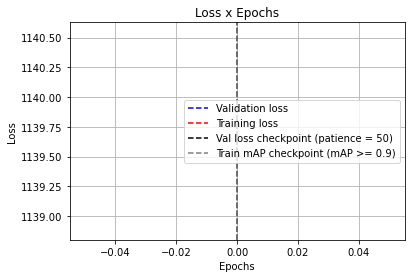

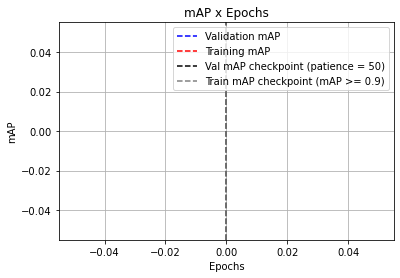

Error in callback <function flush_figures at 0x7f6b8b40cca0> (for post_execute):


KeyboardInterrupt: 

In [13]:
if __name__ == "__main__":
    main()

In [ ]:
loss_graph(show = True)
mAP_graph(show = True)

In [ ]:
18:48
19:53

In [ ]:
1:54